In [1]:
%load_ext watermark
%watermark -v -p torch

Python implementation: CPython
Python version       : 3.9.17
IPython version      : 8.14.0

torch: 2.0.1


In [12]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [3]:
# From local helper files
import sys
sys.path.insert(0, "../")

from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders

# Settings and Dataset

In [4]:

##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 20
NUM_EPOCHS = 15
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
##########################
### MNIST DATASET
##########################

resize_transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize((32, 32)),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5,), (0.5,))])


train_loader, valid_loader, test_loader = get_dataloaders(batch_size=BATCH_SIZE,
                                                          name="MNIST",
                                                          validation_size_or_fraction=50000,
                                                          train_transforms=resize_transform,    
                                                          test_transforms=resize_transform)

print('size of sample train dataset:', len(train_loader))
# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

100%|██████████| 9912422/9912422 [00:00<00:00, 22203364.52it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 28362372.71it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 7380895.17it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5405938.92it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw


size of sample train dataset: 500
Image batch dimensions: torch.Size([20, 1, 32, 32])
Image label dimensions: torch.Size([20])
Class labels of 10 examples: tensor([5, 8, 9, 4, 9, 3, 4, 3, 6, 3])


In [6]:
class LeNet5(torch.nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super(LeNet5, self).__init__()

        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = torch.nn.Sequential(

            torch.nn.Conv2d(in_channels, 6, kernel_size=5),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(6, 16, kernel_size=5),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(16*5*5, 120),
            torch.nn.Tanh(),
            torch.nn.Linear(120, 84),
            torch.nn.Tanh(),
            torch.nn.Linear(84, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

In [8]:
model = LeNet5(grayscale=True,
               num_classes=10)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

# Load State

In [11]:
model.load_state_dict(state_dict=torch.load(f="saved_data/model.pt"))
optimizer.load_state_dict(state_dict=torch.load(f="saved_data/optimizer.pt"))
scheduler.load_state_dict(state_dict=torch.load(f="saved_data/scheduler.pt"))

# Train 

Epoch: 001/015 | Batch 0000/0500 | Loss: 0.0026
Epoch: 001/015 | Batch 0100/0500 | Loss: 0.0011
Epoch: 001/015 | Batch 0200/0500 | Loss: 0.0009
Epoch: 001/015 | Batch 0300/0500 | Loss: 0.0004
Epoch: 001/015 | Batch 0400/0500 | Loss: 0.0039
Epoch: 001/015 | Train: 100.00% | Validation: 97.87%
Time elapsed: 0.19 min
Epoch: 002/015 | Batch 0000/0500 | Loss: 0.0005
Epoch: 002/015 | Batch 0100/0500 | Loss: 0.0006
Epoch: 002/015 | Batch 0200/0500 | Loss: 0.0009
Epoch: 002/015 | Batch 0300/0500 | Loss: 0.0000
Epoch: 002/015 | Batch 0400/0500 | Loss: 0.0003
Epoch: 002/015 | Train: 100.00% | Validation: 97.89%
Time elapsed: 0.37 min
Epoch: 003/015 | Batch 0000/0500 | Loss: 0.0010
Epoch: 003/015 | Batch 0100/0500 | Loss: 0.0006
Epoch: 003/015 | Batch 0200/0500 | Loss: 0.0002
Epoch: 003/015 | Batch 0300/0500 | Loss: 0.0036
Epoch: 003/015 | Batch 0400/0500 | Loss: 0.0009
Epoch: 003/015 | Train: 100.00% | Validation: 97.87%
Time elapsed: 0.55 min
Epoch: 004/015 | Batch 0000/0500 | Loss: 0.0004
Epoc

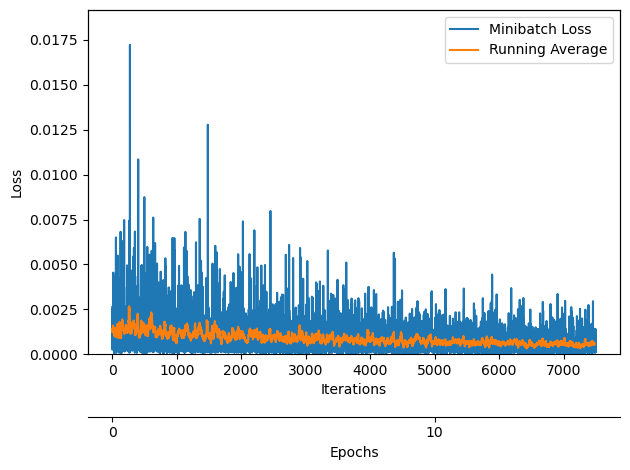

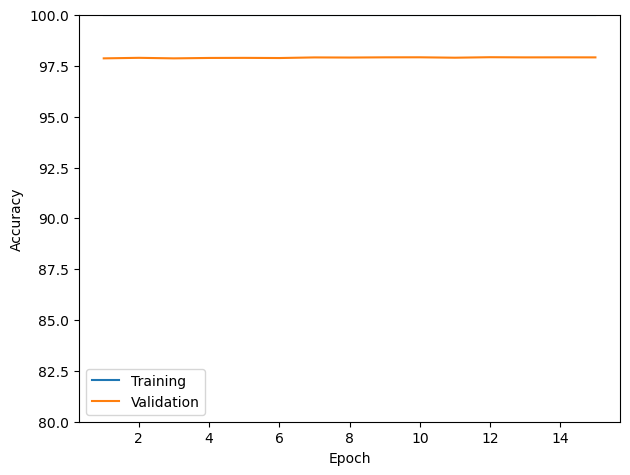

In [13]:
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([80, 100])
plt.show()

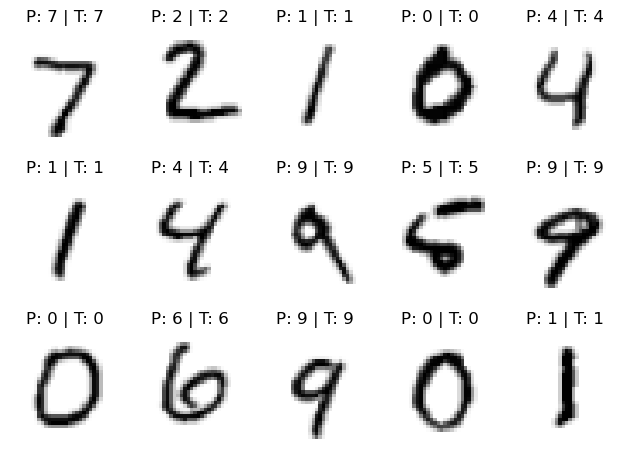

In [14]:
show_examples(model=model, data_loader=test_loader)